In [1]:
!which python; python --version

/Users/swagatam/miniconda3/envs/sbi_dev/bin/python
Python 3.10.16


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

seed = 2025
torch.manual_seed(seed);

from sbi.analysis import pairplot
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

/Users/swagatam/miniconda3/envs/sbi_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sbi.diagnostics.misspecification import calculate_p_misspecification

### Define true (well-specified) and misspecified priors
We only handle prior misspecification for now.
- True prior -- the $x_{obs}$ will come from this
- Misspecified prior -- the NPE will be trained on $(\theta, x)$ pairs coming from this prior
- Simulator code is same in both cases

In [4]:
dim = 2 # observation dimension
# true prior -- the observation comes from here
mean_true = torch.zeros(dim)
cov_true = torch.eye(dim)
prior_true = dist.MultivariateNormal(loc=mean_true, covariance_matrix=cov_true)

# the NPE will be trained on samples from this misspecified prior
def give_misspec_prior(mu0, tau0):
    if mu0.ndim > 1:
        raise ValueError(
                "mu0 should be a 1d tensor of shape [dim]"
            )
    dim = mu0.shape[0]
    return dist.MultivariateNormal(loc=mu0, covariance_matrix=tau0*torch.eye(dim))

offset = 3
mu0 = mean_true + offset # just offset, applies in all directions
tau0 = 1.0 # 1.0 means no change in covariance matrix
prior_mis = give_misspec_prior(mu0, tau0)

def simulator(theta):
    return theta + torch.randn_like(theta)

In [5]:
# test
prior_mis.sample_n(100_000).mean(0), prior_true.sample_n(100_000).mean(0)

/var/folders/qp/4w02sqhj6_d43815lhzjb7900000gn/T/ipykernel_32863/3152808367.py:2: FutureWarning: `sample_n(n)` will be deprecated. Use `sample((n,))` instead.
  prior_mis.sample_n(100_000).mean(0), prior_true.sample_n(100_000).mean(0)


(tensor([2.9984, 2.9970]), tensor([-0.0022,  0.0043]))

### Create dataset, i.e., $(\theta, x)$ pairs to train NPEs
We will have 2 datasets:
- one case is for the well-specified prior
- the second is the misspecified prior

We will also generate a validation dataset, to compute "self MMD" or the distribution of MMDs to ultimately check

In [6]:
num_simulations = 1000 # K in the paper

# generate training data for clean/well-specified model
theta_well = prior_true.sample((num_simulations, ))
x_well = simulator(theta_well)


# generate training data from misspecified model, currently only supports prior misspecification
# note that we are sampling theta from a misspecified (wrt x_obs) prior
theta_mis = prior_mis.sample((num_simulations, )) 
x_mis = simulator(theta_mis)


# validation set to compute MMD distribution in the well-specified case
# this could just be a subset of the training data
num_validations_mmd = 1000
theta_val_well = prior_true.sample((num_validations_mmd, ))
x_val_well = simulator(theta_val_well)


# validation set to compute MMD distribution in the misspecified case
theta_val_mis = prior_mis.sample((num_validations_mmd, ))
x_val_mis = simulator(theta_val_mis)

print(theta_well.shape, theta_mis.shape, theta_val_well.shape, theta_val_mis.shape)

torch.Size([1000, 2]) torch.Size([1000, 2]) torch.Size([1000, 2]) torch.Size([1000, 2])


### NPE training utilities with and without embedding networks

In [7]:
from sbi.neural_nets.embedding_nets import FCEmbedding, PermutationInvariantEmbedding
from sbi.neural_nets import posterior_nn

def train_npe(theta, x, prior, **kwargs):
    inference = NPE(prior=prior, **kwargs)
    inference = inference.append_simulations(theta, x)
    _ = inference.train()
    return inference

def train_npe_with_embedding(theta, x, prior, embeddding_net, **kwargs):
    neural_posterior = posterior_nn(model='maf', embedding_net=embeddding_net)
    inference = NPE(prior=prior, density_estimator=neural_posterior, **kwargs)
    inference = inference.append_simulations(theta, x)
    _ = inference.train()
    return inference

### Train NPEs for 4 cases

In [8]:
# Case1: train NPE with well specified model without embedding
NPE_well = train_npe(theta_well, x_well, prior=prior_true)

# Case2: train NPE with misspecified model without embedding
NPE_mis = train_npe(theta_mis, x_mis, prior=prior_mis)

# Case3: with embeddings, no misspec
emb_net_well = FCEmbedding(input_dim=dim, output_dim=dim, num_layers=2, num_hiddens=20) # minimal embedding network
NPE_well_embd = train_npe_with_embedding(theta_well, x_well, prior=prior_true, embeddding_net=emb_net_well) # modified the emb_net

# Case4: with embeddings, misspec
emb_net_mis = FCEmbedding(input_dim=dim, output_dim=dim, num_layers=2, num_hiddens=20)
NPE_mis_embd = train_npe_with_embedding(theta_mis, x_mis, prior=prior_mis, embeddding_net=emb_net_mis) # modifies the emb_net

 Neural network successfully converged after 155 epochs.

In [22]:
net1 = NPE_mis_embd._neural_net.embedding_net
net2 = NPE_mis._neural_net.embedding_net

net1, net2

(Sequential(
   (0): Standardize()
   (1): FCEmbedding(
     (net): Sequential(
       (0): Linear(in_features=2, out_features=20, bias=True)
       (1): ReLU()
       (2): Linear(in_features=20, out_features=2, bias=True)
       (3): ReLU()
     )
   )
 ),
 Sequential(
   (0): Standardize()
   (1): Identity()
 ))

In [38]:
isinstance(net2[1], nn.modules.linear.Identity)

True

In [36]:
net2[1]

Identity()

### Create an observation $x_{obs}$
Note that this observation comes from a true prior parameter

In [9]:
# do inference given observed data
num_observations = 1
theta_o = prior_true.sample((num_observations, ))
x_o = simulator(theta_o)

print(f"theta_o (comes from true prior): {theta_o}")
print(f"x_o (comes from simulator using theta_o): {x_o}")

theta_o (comes from true prior): tensor([[0.9590, 0.6317]])
x_o (comes from simulator using theta_o): tensor([[ 0.6227, -0.3214]])


### Case 1: well specified model, no embeddings, so we just check MMDs on the original $x$ space
- since the model is well-specified, we can compute MMD distribution on `x_val_well`

p-val: 0.968000


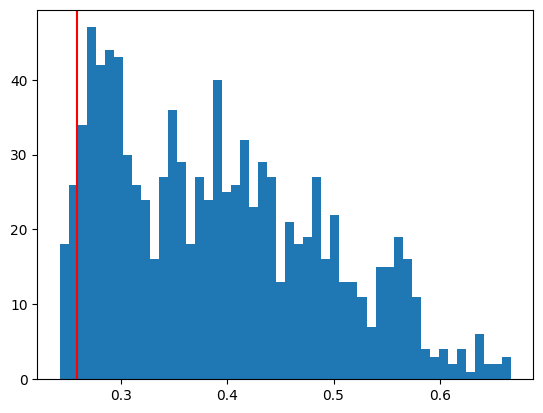

In [10]:
p_val, (mmds_baseline, mmd) = calculate_p_misspecification(x_o, x_val_well, n_shuffle=1000, max_samples=1000, mode="biased")
print(f"p-val: {p_val:.6f}")
plt.hist(mmds_baseline.numpy(), bins=50)
plt.axvline(mmd.item(), color="red")
plt.show()

In [11]:
from sbi.diagnostics.misspecification import calculate_baseline_mmd, compute_rbf_mmd_median_heuristic

### Case 2: misspecified model, no embeddings, so again we just check MMDs on the original $x$ space
- but this time MMD distribution needs to be calculated on the misspecified data

p-val: 0.006000


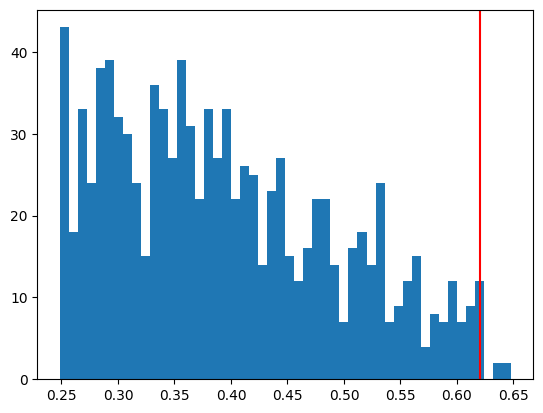

In [12]:
# mmds_baseline = calculate_baseline_mmd(x_o, x_val_mis, n_shuffle=1000, max_samples=1000, mode="biased") # 1000 mmds between the samples in x, x_obs is only needed for its shape
# mmd = compute_rbf_mmd_median_heuristic(x_o, x_val_mis, mode="biased")
# plt.hist(mmds_baseline.numpy(), bins=50)
# plt.axvline(mmd.item(), color="red")
# plt.show()


p_val, (mmds_baseline, mmd) = calculate_p_misspecification(x_o, x_val_mis, n_shuffle=1000, max_samples=1000, mode="biased")
print(f"p-val: {p_val:.6f}")
plt.hist(mmds_baseline.numpy(), bins=50)
plt.axvline(mmd.item(), color="red")
plt.show()

### Case 3: well specified model, with embeddings, so now we check MMDs on the embedded $z$ space

In [13]:
z_val_well = emb_net_well(x_val_well).detach()
z_o = emb_net_well(x_o).detach()

In [14]:
# z_val_well

p-val: 0.914000


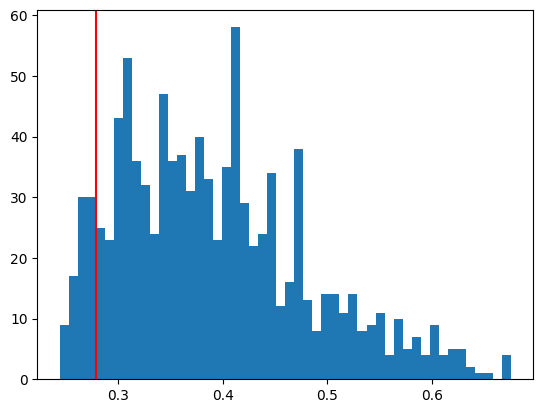

In [15]:
# mmds_baseline = calculate_baseline_mmd(z_o, z_val, n_shuffle=1000, max_samples=1000, mode="biased")
# mmd = compute_rbf_mmd_median_heuristic(z_o, z_val, mode="biased")
# plt.hist(mmds_baseline.numpy(), bins=50)
# plt.axvline(mmd.item(), color="red")
# plt.show()


p_val, (mmds_baseline, mmd) = calculate_p_misspecification(z_o, z_val_well, n_shuffle=1000, max_samples=1000, mode="biased")
print(f"p-val: {p_val:.6f}")
plt.hist(mmds_baseline.numpy(), bins=50)
plt.axvline(mmd.item(), color="red")
plt.show()

### Case 4: misspecified model, with embeddings, so now we check MMDs on the embedded $z$ space

In [16]:
z_val_mis = emb_net_mis(x_val_mis).detach()
z_o = emb_net_mis(x_o).detach()

In [17]:
z_val_mis

tensor([[1.1027, 0.0000],
        [0.2768, 0.0000],
        [0.9312, 0.0000],
        ...,
        [0.6617, 0.0000],
        [1.2044, 0.0000],
        [0.5643, 0.0000]])

p-val: 0.054000


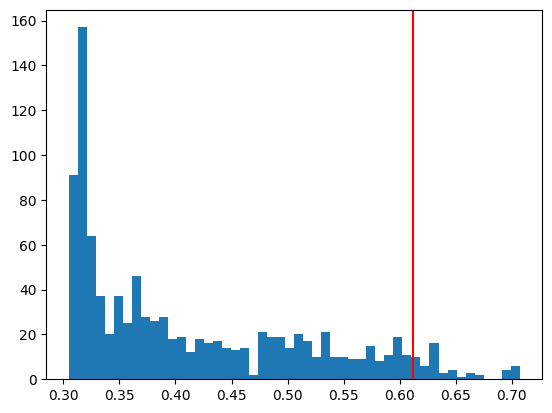

In [18]:
# mmds_baseline = calculate_baseline_mmd(z_o, z_val_mis, n_shuffle=1000, max_samples=1000, mode="biased")
# mmd = compute_rbf_mmd_median_heuristic(z_o, z_val_mis, mode="biased")
# plt.hist(mmds_baseline.numpy(), bins=50)
# plt.axvline(mmd.item(), color="red")
# plt.show()


p_val, (mmds_baseline, mmd) = calculate_p_misspecification(z_o, z_val_mis, n_shuffle=1000, max_samples=1000, mode="biased")
print(f"p-val: {p_val:.6f}")
plt.hist(mmds_baseline.numpy(), bins=50)
plt.axvline(mmd.item(), color="red")
plt.show()